# Classical convolutional model LeNet for MNIST
For handwriten digits classification, LeNet concluded some research in CNN. 
Bring out a classical structure of CNN model.
And In this notebook, we try to apply the LeNet on Fashion MNIST dataset to classification.

The LeNet structure following on the below figure.

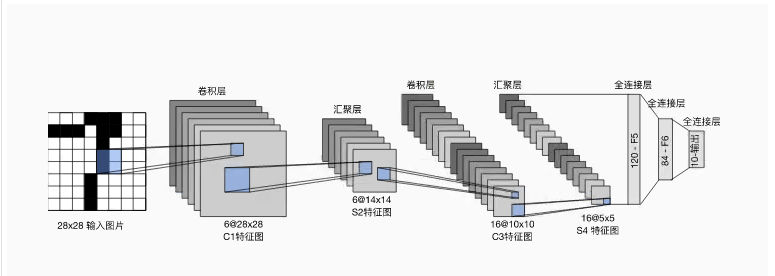

In [2]:
import torch
import torch.nn as nn 
from torchvision import datasets, transforms
from matplotlib import pyplot as plt 
from d2l import torch as d2l

## Dataset

In [3]:
data_path = './data/Fashion_mnist'
mnist = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
mnist_val = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

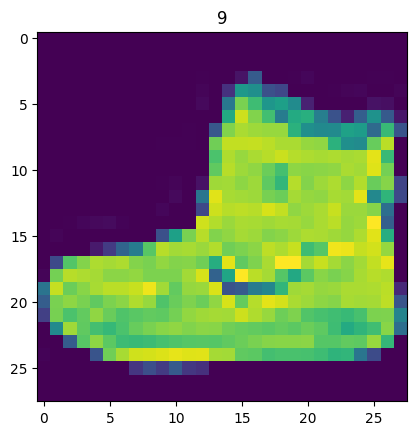

In [4]:
# visualize the dataset. 
img, label = mnist[0]
plt.imshow(img.permute(1,2,0))
plt.title(str(label))
plt.show()

## LeNet and some modifications.

At the time of Yann LeCun brought out LeNet, the ReLU and max pooling were not present. But on some research after proved ReLU and max pooling have better performance.

At this notebook, we do some update on the classical LeNet replaced by RelU for activation and max pooling to downsample.

In [5]:
LeNet = nn. Sequential (
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), # 28*28
    nn.AvgPool2d(kernel_size=2, stride=2), # 14*14
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), # 10*10
    nn.AvgPool2d(kernel_size=2, stride=2), # 5 * 5
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(), 
    nn.Linear(120, 84), nn.Sigmoid(), 
    nn.Linear(84, 10)
)

In [6]:
# print forward propagation
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in LeNet:
    X = layer (X)
    print (layer.__class__.__name__, 'output shape: It', X.shape)

Conv2d output shape: It torch.Size([1, 6, 28, 28])
Sigmoid output shape: It torch.Size([1, 6, 28, 28])
AvgPool2d output shape: It torch.Size([1, 6, 14, 14])
Conv2d output shape: It torch.Size([1, 16, 10, 10])
Sigmoid output shape: It torch.Size([1, 16, 10, 10])
AvgPool2d output shape: It torch.Size([1, 16, 5, 5])
Flatten output shape: It torch.Size([1, 400])
Linear output shape: It torch.Size([1, 120])
Sigmoid output shape: It torch.Size([1, 120])
Linear output shape: It torch.Size([1, 84])
Sigmoid output shape: It torch.Size([1, 84])
Linear output shape: It torch.Size([1, 10])


## Train model

In [7]:
batch_size = 256
train_loader = torch.utils.data.DataLoader (mnist, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader (mnist_val, batch_size=batch_size, shuffle=True)

In [14]:
def evaluate_accuracy_gpu (net, data_loader, device=None):
    if isinstance(net, nn.Module):
        net.eval() # setting module on evaluate mode. 
        if not device:
            device = next(iter(net.parameters())).device
        correct = 0
        total = 0
        with torch. no_grad():
            for x, y in data_loader: 
                if isinstance(x, list):
                    x = [e.to(device) for e in x]
                else:
                    x = x.to(device)
                y = y.to(device)
                out = net(x)
                _, predicted = torch.max(out, dim=1)
                correct += int((predicted == y).sum())
                total += y.shape[0]
    return correct / total

In [9]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [12]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print(mps_device)

mps


loss 0.463, train acc 0.826, test acc 0.815
37610.5 examples/sec on mps


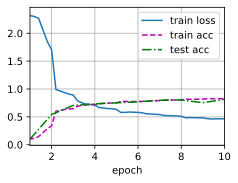

In [15]:
lr, num_epochs = 0.9, 10

train_ch6(LeNet, train_loader, val_loader, num_epochs, lr, mps_device)